# News Classification using fine tuned bert model

I am going to add additional layers on 'bert-base-cased' for clssification task. In this code I froze all the layers of the model and attached 3 neural network layers of my own and train this new model.

Importing all useful functions and libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import transformers
from transformers import AutoTokenizer,TFBertModel

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

from sklearn.metrics import confusion_matrix

Loading training data set

In [2]:
train_data = pd.read_csv('train.csv')
train_data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Checking for null values

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


Creating training dataset

In [4]:
## Combining title and description of news to make single text sequence
X_train = train_data['Title'] +" "+ train_data['Description']

## bringing label to range of 0 to 3 from range of 1 to 4
y = train_data['Class Index'].apply(lambda x: x-1)

## One hot encoding labels
y_train = pd.get_dummies(y,dtype=int)

Loading and Creating test dataset

In [28]:
test_data = pd.read_csv('test.csv')
X_test = test_data['Title'] +" "+ test_data['Description']
y_test = test_data['Class Index'].apply(lambda x:x-1)

Importing pre-trained transformer model and tokeniser for same model to ensure same style of encoding is followed as used while training original model

In [6]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

## Pre-processing

Tokenising training and test dataset using pre-trained tokeniser. Max_length is chosen as 75 on basis of distribution of sequences length. 

In [7]:
## Training dataset tokenisation
x_train = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=75,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

## Test dataset tokenisation
x_test = tokenizer(
    text=X_test.tolist(),
    add_special_tokens=True,
    max_length=75,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [8]:
## Extract input_ids and attenstion mask from tokenised data 
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

## Fine tuning

Freezing the entire architecture to ensure that weights of only the attached layers will be updated during model training. 

In [9]:
for layer in bert.layers:
    layer.trainable=False
    for w in layer.weights: w._trainable=False

Attaching extra layers on pre-trained model for classification

I am using last hidden state from bert and putting it through GlobalMaxPooling1D followed by 2 dense layer and output layer

In [10]:
max_len = 75
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(64, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 75)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 75)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 75, 76                                       

Training models

In [11]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [12]:

model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs= 2,
    batch_size= 64, verbose = 1
)

Epoch 1/2
1875/1875 [==============================] - 666s 352ms/step - loss: 0.5200 - accuracy: 0.8095 - val_loss: 0.3763 - val_accuracy: 0.8709
Epoch 2/2
1875/1875 [==============================] - 659s 351ms/step - loss: 0.4070 - accuracy: 0.8577 - val_loss: 0.3594 - val_accuracy: 0.8739


Saving model to avoid retraining each time

In [13]:
model.save('bert_tf_tuned', save_format='tf')

## Evaluating model

Predicting class of examples in test dataset and saving it in vector form for further analysis

In [16]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
y_pred = np.argmax(predicted_raw, axis = 1)

238/238 [==============================] - 40s 167ms/step


### Accuracy

Calculating Accuracy of model on test dataset

In [20]:
model.evaluate({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test)

238/238 [==============================] - 42s 175ms/step - loss: 0.3594 - accuracy: 0.8739


[0.3594435155391693, 0.8739473819732666]

Loss on test dataset = 0.36

Accuracy on test dataset = 0.87

### Confusion Matrix

<Axes: >

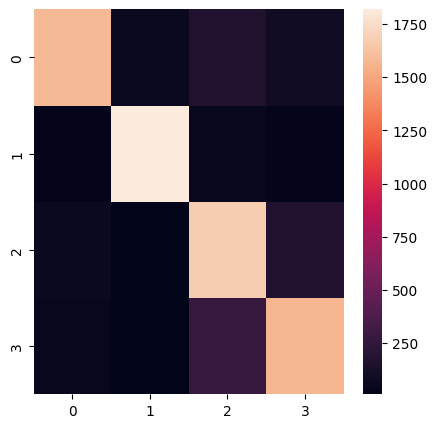

In [29]:
confusion_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
df_cm = pd.DataFrame(confusion_mat, index = list(range(4)),columns = list(range(4)))
plt.rcParams['figure.figsize'] = (5,5)
sns.heatmap(df_cm)

From the confusion matrix, it is evident that model is performing very well for all classes

### Classification report

In [30]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(y_test, y_pred))

classifiation report
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1900
           1       0.95      0.96      0.96      1900
           2       0.78      0.88      0.83      1900
           3       0.85      0.83      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.88      0.87      0.87      7600
weighted avg       0.88      0.87      0.87      7600



From the report, we can infer that 
1. model is performing very good in classifying news in correct class as both precision and recall is near 1 for all classes.
2. Model is performing best for class '1' and worst(relatively, it's still good) for class '2' according to f1 score. Similar trend is found in lstm based model

I have referred to following article for learning how to attach neural network layer on bert -  https://www.analyticsvidhya.com/blog/2021/12/multiclass-classification-using-transformers/